In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

#Use white backgrund for matplotlib figures
matplotlib.rcParams['figure.facecolor']='#ffffff'

In [2]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())

Image shape: torch.Size([1, 28, 28])
Label: 5


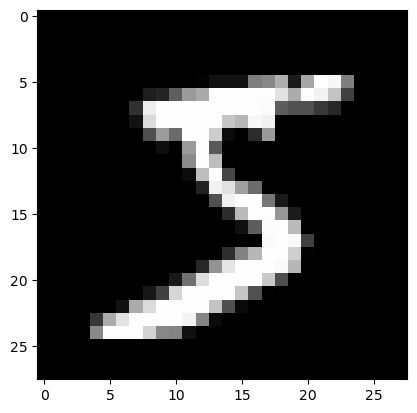

In [3]:
image,label =dataset[0]
print('Image shape:',image.shape)
plt.imshow(image.permute(1,2,0),cmap='gray')
print("Label:",label)

In [4]:
val_size=10000
train_size=len(dataset)-val_size

train_ds, val_ds = random_split(dataset, (train_size,val_size))
len(train_ds),len(val_ds)

(50000, 10000)

In [5]:
batch_size=128

In [6]:
train_loader=DataLoader(train_ds,batch_size, shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

images.shape: torch.Size([1, 28, 28])


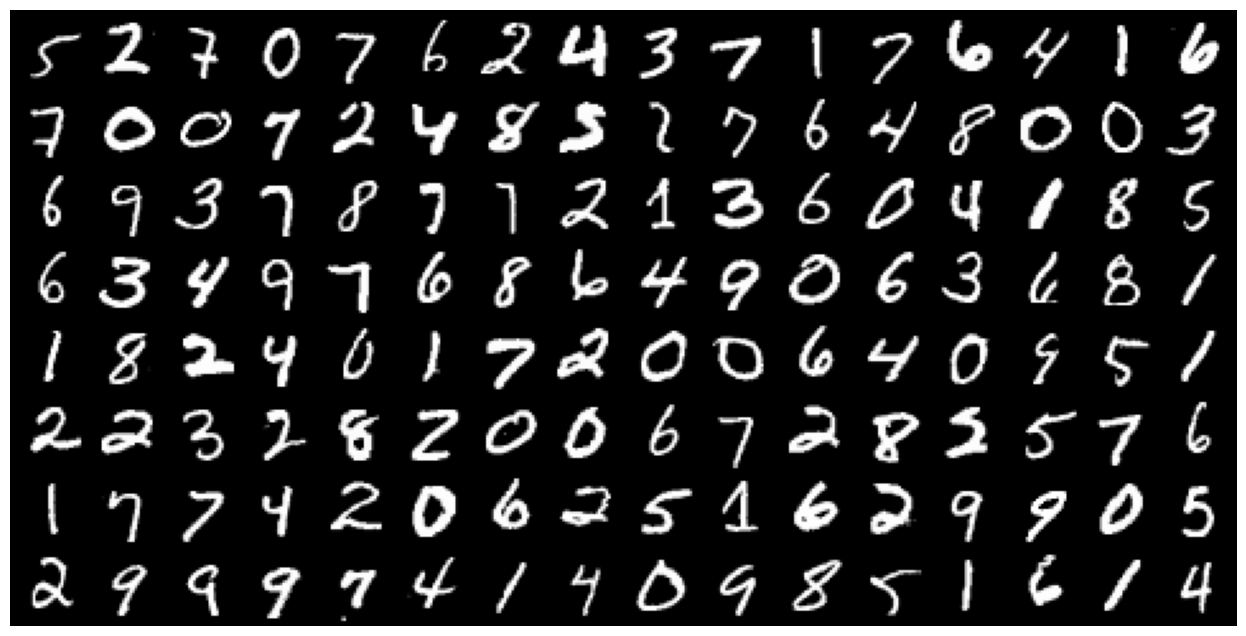

In [7]:
for images,_ in train_loader:
    print("images.shape:",image.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

### Hidden Layers, Activation Functions and Non-Linearity

In [8]:
for images,labels in train_loader:
    print("image.shape:",images.shape)
    inputs=images.reshape(-1,784)
    print("Input shape:",inputs.shape)
    break

image.shape: torch.Size([128, 1, 28, 28])
Input shape: torch.Size([128, 784])


In [9]:
input_size=inputs.shape[-1]
hidden_size=32

In [10]:
layer1=nn.Linear(input_size,hidden_size)

In [11]:
layer1_outputs=layer1(inputs)
print("layer1_outputs.shape:",layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [12]:
layer1_outputs_direct = inputs @layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [13]:
torch.allclose(layer1_outputs,layer1_outputs_direct,1e-3)

True

In [14]:
F.relu(torch.tensor([[1,-1,0],
                     [-0.1,.2,3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [15]:
relu_outputs=F.relu(layer1_outputs)
print("min(layer1_outputs):",torch.min(layer1_outputs).item())
print("min(relu_outputs):",torch.min(relu_outputs).item())

min(layer1_outputs): -0.7251582741737366
min(relu_outputs): 0.0


In [16]:
relu_outputs.shape

torch.Size([128, 32])

In [17]:
output_size=10
layer2= nn.Linear(hidden_size,output_size)

In [18]:
layer2_outputs=layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [19]:
inputs.shape

torch.Size([128, 784])

In [20]:
relu_outputs.shape

torch.Size([128, 32])

In [21]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.2826, grad_fn=<NllLossBackward0>)

In [22]:
# Expanded version of layer2(F.relu(layer2(inputs)))
outputs = (F.relu(inputs@layer1.weight.t()+layer1.bias))@layer2.weight.t()+layer2.bias

In [23]:
torch.allclose(outputs,layer2_outputs,1e-3)

True

### Define Model

In [24]:
class MnistModel(nn.Module):
    """Feedforward neural notwrk with 1 hidden layer"""
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        # Hidden layer
        self.linear1 = nn.Linear(in_size,hidden_size)
        # Output layer
        self.linear2 = nn.Linear(hidden_size,out_size)

    def forward(self,xb):
        #Flatten the image tensors
        xb=xb.view(xb.size(0),-1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # get predictions using output layer
        out = self.linear2(out)
        return out
        
    def training_step(self,batch):
        images,labels=batch
        out=self(images)                   # Generate predictions
        loss = F.cross_entropy(out,labels) #Calculate loss
        return loss
        
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)                 # Generate Predictions
        loss = F.cross_entropy(out,labels) # Calculate Loss
        acc = accuracy(out,labels)         # Calculate accuracy
        return {'val_loss' : loss , 'val_acc':acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # Combine Losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
        
    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch} , val_loss: {result['val_loss']} , val_acc:{result['val_acc']}")
    

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [25]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [26]:
input_size =784
hidden_size=32 
num_classes=10

In [27]:
model=MnistModel(input_size,hidden_size,out_size=num_classes)

In [28]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [29]:
for images, labels in train_loader:
    output = model(images)
    loss = F.cross_entropy (outputs,labels)
    print(f"Loss : {loss}")
    break

print(f"Outputs shape: {outputs.shape}")
print(f"Sample outputs: {outputs[:2].data}")

Loss : 2.306823253631592
Outputs shape: torch.Size([128, 10])
Sample outputs: tensor([[-0.1911,  0.0908,  0.1827,  0.0971,  0.1468, -0.0659, -0.0386,  0.0423,
         -0.0183, -0.1907],
        [-0.1230,  0.0356,  0.1993, -0.0089,  0.2134,  0.0200,  0.0383,  0.0968,
         -0.0281, -0.1821]])


### Using GPU

In [30]:
torch.cuda.is_available()

True

#### Define helper function to use GPU

In [31]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [32]:
device=get_default_device()
device

device(type='cuda')

In [33]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [34]:
for images,labels in train_loader:
    print(images.shape)
    print(images.device)
    images=to_device(images,device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu
cuda:0


### Class for load data to GPU

In [35]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [36]:
def some_number():
    yield 10
    yield 20
    yield 30

for value in some_number():
    print(value)

10
20
30


In [37]:
train_loder =DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

In [38]:
for xb,yb in val_loader:
    print("xb.device:", xb.device)
    print("yb:",yb)
    break

xb.device: cuda:0
yb: tensor([3, 7, 1, 6, 0, 7, 8, 7, 0, 7, 6, 2, 6, 1, 8, 7, 8, 7, 8, 5, 7, 0, 7, 9,
        6, 8, 6, 2, 8, 1, 0, 1, 1, 8, 2, 6, 9, 5, 8, 5, 7, 3, 2, 0, 5, 7, 6, 9,
        9, 1, 4, 9, 0, 1, 1, 2, 0, 3, 5, 5, 7, 1, 2, 5, 7, 5, 2, 5, 6, 8, 7, 9,
        7, 6, 8, 5, 2, 7, 6, 0, 7, 8, 4, 8, 0, 9, 7, 2, 3, 5, 0, 8, 1, 2, 9, 6,
        2, 4, 0, 0, 2, 9, 4, 0, 9, 3, 6, 1, 8, 7, 5, 0, 5, 8, 7, 8, 6, 5, 2, 7,
        1, 1, 2, 7, 1, 3, 9, 7, 5, 0, 2, 3, 2, 2, 6, 4, 4, 4, 2, 4, 0, 1, 9, 2,
        9, 8, 2, 3, 1, 3, 3, 1, 5, 0, 5, 6, 3, 5, 9, 6, 3, 2, 9, 0, 9, 9, 2, 1,
        4, 9, 5, 8, 1, 6, 0, 5, 6, 5, 6, 6, 9, 0, 2, 9, 6, 8, 3, 8, 1, 5, 2, 9,
        0, 2, 2, 3, 6, 4, 3, 8, 9, 3, 8, 2, 6, 4, 5, 7, 2, 0, 1, 1, 2, 2, 5, 6,
        3, 4, 1, 7, 2, 8, 5, 1, 4, 2, 9, 7, 6, 6, 9, 5, 6, 2, 5, 9, 1, 7, 2, 1,
        5, 6, 7, 7, 8, 4, 9, 3, 0, 6, 5, 7, 0, 2, 0, 5], device='cuda:0')


### Train the Model

In [39]:
def evaluate(model,val_loder):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs,lr, model,train_loader,val_loader,opt_func=torch.optim.SGD):
    """Train the model using Gradient decent"""
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        #Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model,val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history        

In [44]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [45]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.313701868057251, 'val_acc': 0.10126952826976776}]

In [46]:
history += fit(10,0.5,model, train_loader, val_loader)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)